# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

## 0 Prerequisites

### 0.0 Import packages and ModelClass

In [1]:
%load_ext autoreload
%autoreload 2

# standard packages
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

# local modules
import figs
import analyse as ana
import validate
from HAHModel import HAHModelClass

### 0.1 Import data for equivalence scale and life cycle income profile

In [2]:
# read data
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 

## 1 Baseline model

In [3]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 48.1 secs
 t = 2 solved in 44.7 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 56.8 secs
 total stay-time  = 8.5 secs
 total ref-time   = 10.5 secs
 total buy-time   = 8.2 secs
 total rent-time   = 8.8 secs
 full model solved in = 92.8 secs
model simulated in 54.9 secs
numba precompiled in 151.4 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 1.2 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.6 secs
 v_bar and q computed in 2.2 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 2.5 secs
 v_bar and q computed in

In [5]:
# simulate the model forward to reach stable bequest distribution
import steady_state
np.random.seed(1995)
par = model_baseline.par
sim = model_baseline.sim
draws1 = np.random.uniform(size=par.simN)
draws2 = np.random.uniform(size=(par.T*par.simN))
draws3 = np.random.lognormal(mean=par.mu_a0,sigma=par.sigma_a0,size=par.simN) # fixed draws for all models
assert np.all(np.isclose(sim.a0,draws3)), 'draws are not equal to initial wealth'
steady_state.bequest_loop(model_baseline,draws3,bequest_guess=1.77,step_size=0.99) # 1.776066

iteration = 1, discrepancy in means = -0.026281
iteration = 2, discrepancy in means = -0.018615
iteration = 3, discrepancy in means = -0.013236
iteration = 4, discrepancy in means = -0.009374
iteration = 5, discrepancy in means = -0.006622
iteration = 6, discrepancy in means = -0.004691
iteration = 7, discrepancy in means = -0.003339
iteration = 8, discrepancy in means = -0.002367
iteration = 9, discrepancy in means = -0.001669
iteration = 10, discrepancy in means = -0.001173
iteration = 11, discrepancy in means = -0.000828
iteration = 12, discrepancy in means = -0.000586
iteration = 13, discrepancy in means = -0.000411
iteration = 14, discrepancy in means = -0.000292
iteration = 15, discrepancy in means = -0.000213
iteration = 16, discrepancy in means = -0.000151
iteration = 17, discrepancy in means = -0.000107
iteration = 18, discrepancy in means = -0.000078
iteration = 19, discrepancy in means = -0.000053
iteration = 20, discrepancy in means = -0.000038
iteration = 21, discrepancy i

### 1.0 Decision Functions

In [56]:
#figs.decision_functions(model_baseline)

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

### 1.1 Life Cycle Behaviour

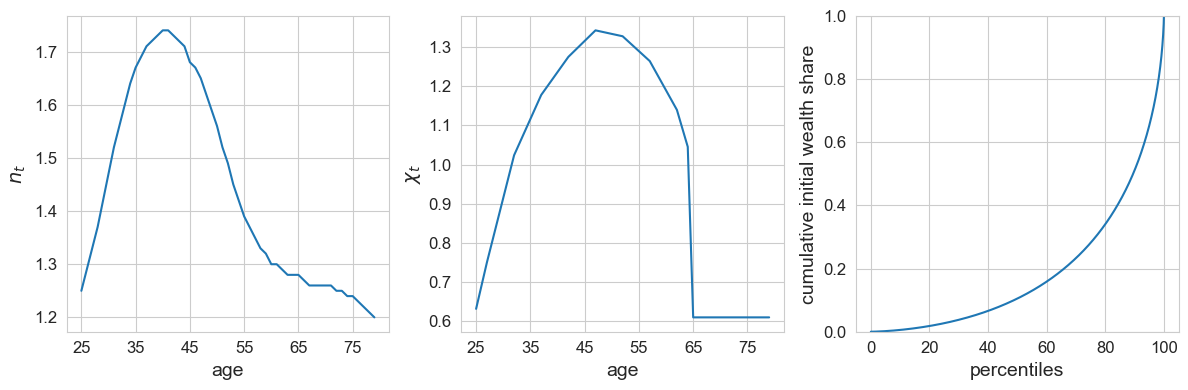

In [6]:
# plot calibration inputs
figs.n_chi_iniwealth(model_baseline,data)

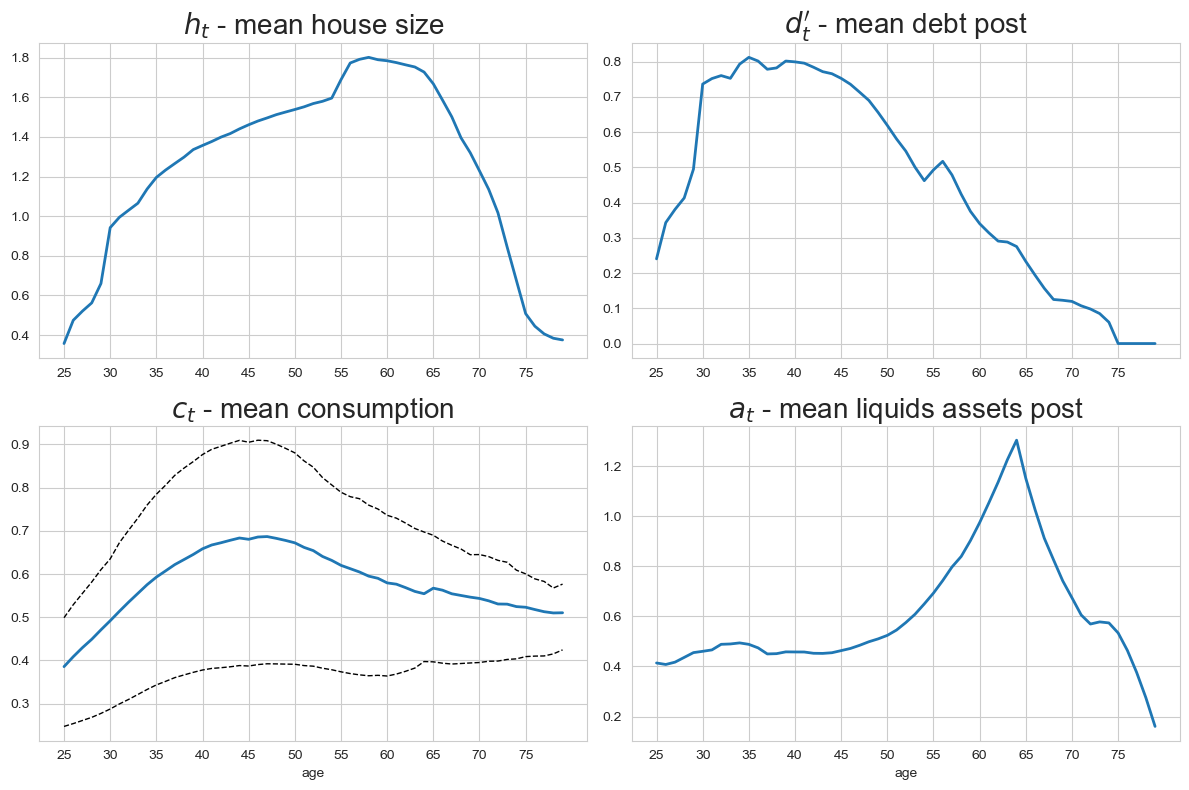

In [7]:
# average behaviour over the life cycle
figs.lifecycle_full(model_baseline)

### 1.2 Life Cycle Behaviour - Model vs. Data

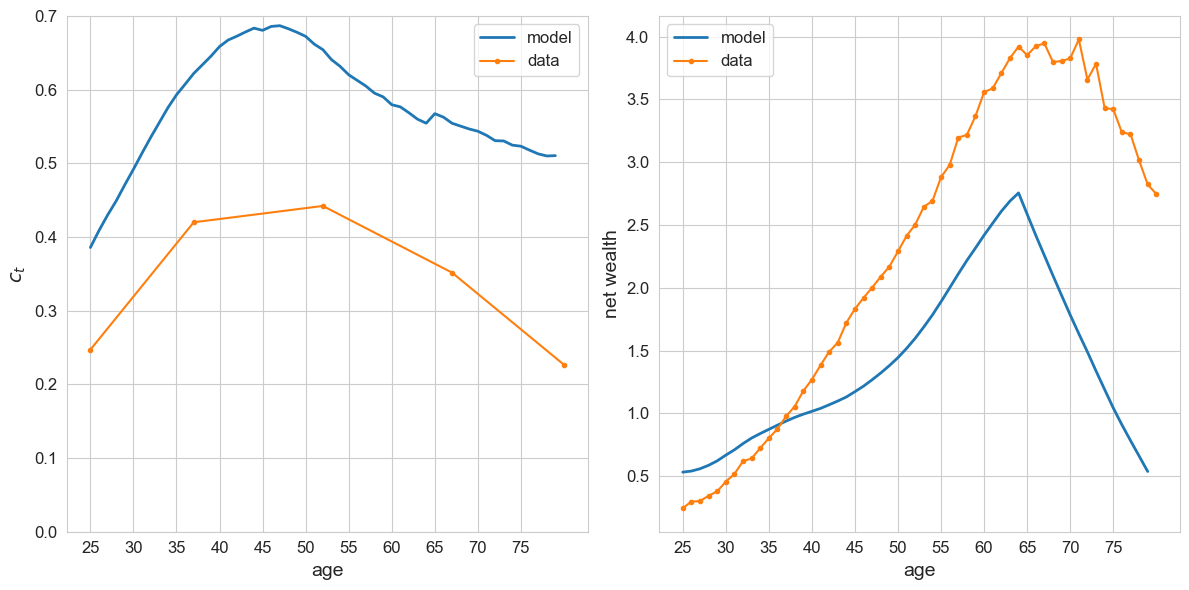

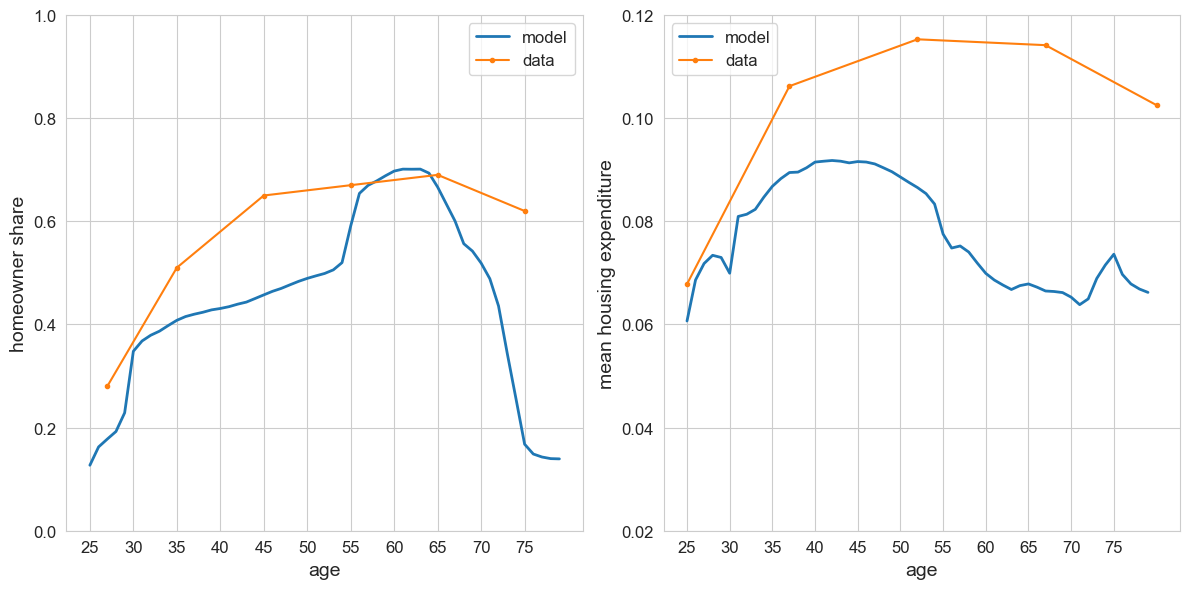

/Users/Christian/Dropbox/KU - Polit/KA/Thesis/MScThesis-2022/figs.py:384: RuntimeWarning: invalid value encountered in true_divide
  DA_shares = np.sum(b_dp_da,axis=1)/np.sum(bool_dp,axis=1)


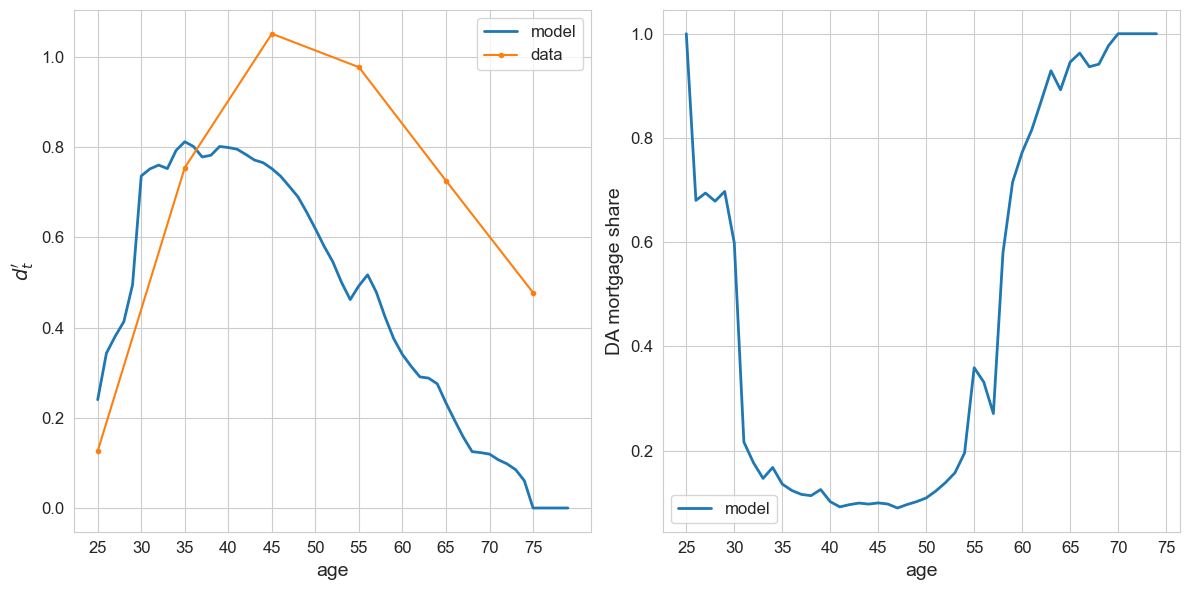

In [8]:
figs.lifecycle_consav(model_baseline)
figs.lifecycle_housing(model_baseline)
figs.lifecycle_mortgage(model_baseline)

### 1.3 Validate simulation

In [9]:
validate.val_sim(model_baseline)
print()
validate.val_finreg(model_baseline)
print()
validate.val_inc_calib_targets(model_baseline)


there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.014994
average mortgage size at origination is 2.2748
the share of DA mortgages at origination is 1.0000
mean LTV is 0.7826 and mean DTI is 1.3041 at mortgage origination

taxes to labour income is 0.3537
median pre tax income is 0.6097
mean property tax is 0.0121
mean pre tax income is 1.0058


### 1.4 Aggregate moments 

In [10]:
# targeted model moments
names_targ, moments_targ = ana.model_moments_targ(model_baseline)
print('Targeted moments from baseline model:')
for i in range(len(names_targ)):
    print(f'  {names_targ[i]} = {moments_targ[i]:.4f}')

Targeted moments from baseline model:
  Aggregate net worth / (annual) labour income = 1.3955
  Annual fraction of houses sold = 0.0501
  Home ownership rate of <35 y.o. = 0.2768
  Mean NW at age 75 / mean NW at age 50 = 0.7220
  Share of households leaving no bequest = 0.4708
  Taxes to labour income = 0.3537


In [11]:
# untargeted model moments
names, moments = ana.model_moments(model_baseline)
print('Untargeted moments from baseline model:')
for i in range(len(names)):
    print(f'  {names[i]} = {moments[i]:.4f}')

Untargeted moments from baseline model:
  Homeowner share = 0.4450
  Mean house size = 2.7995
  Average housing expenditure = 0.0774
  Mean mortgage size = 1.7393
  Share of homeowners with mortgage = 0.5851
  DA mortgage share = 0.3621
  Average LTV ratio = 0.7046
  Average DTI ratio = 1.2443
  Gini wealth coefficient = 0.6811


### 1.5 Discrete choices over the lifecycle

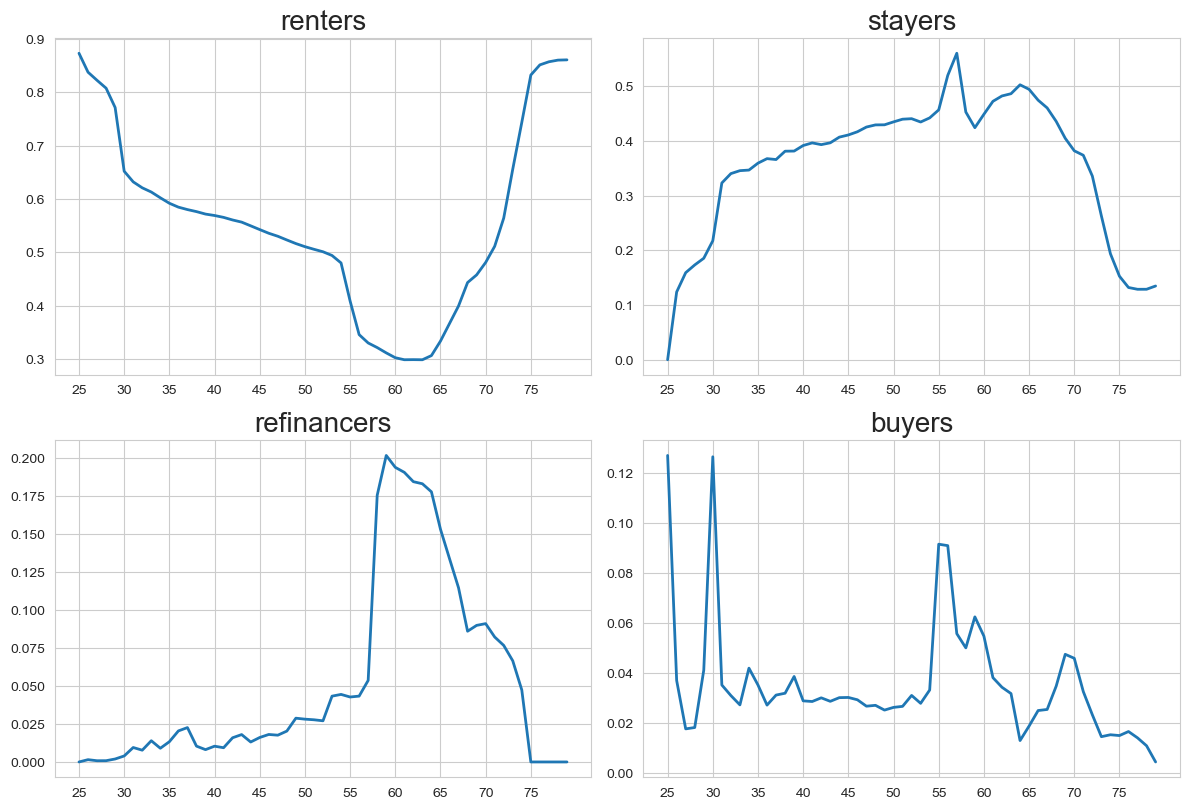

In [12]:
figs.homeownership(model_baseline)

### 1.6 Inspect the life cycle profile of a given household

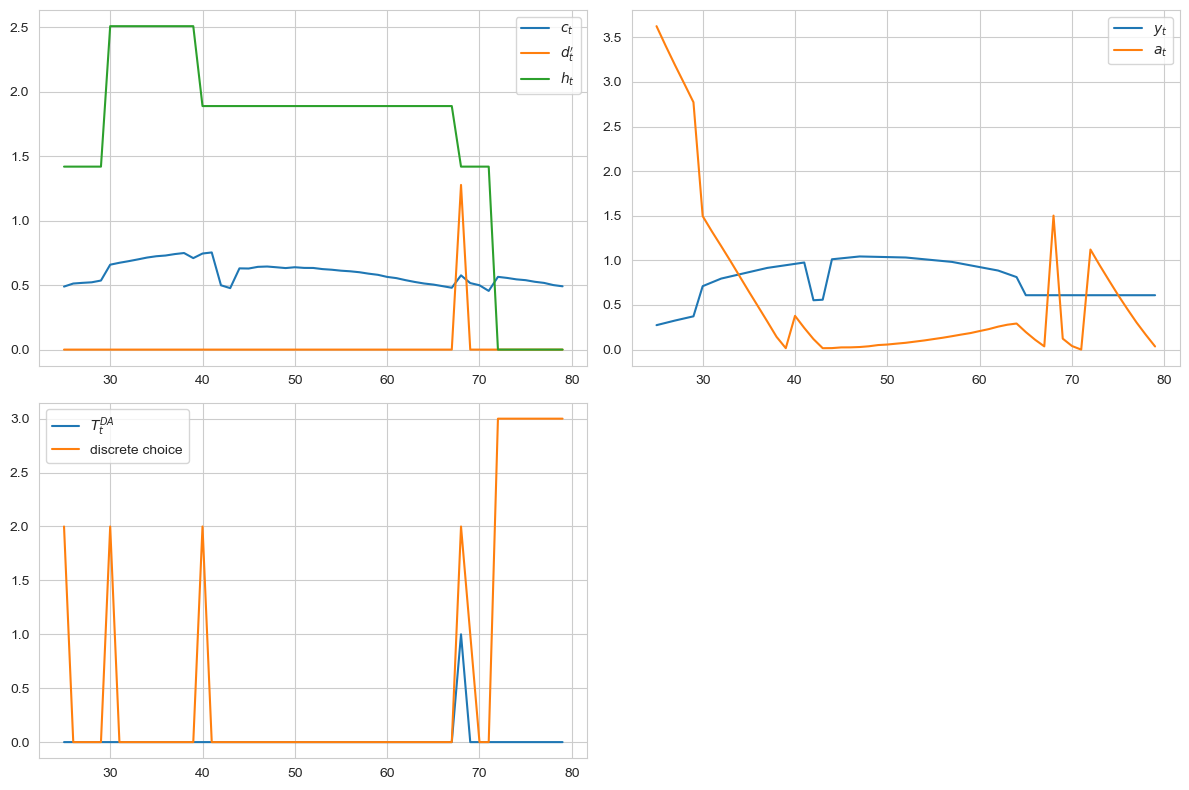

In [14]:
figs.example_household(model_baseline,hh_no=5_000)

## 2 Model without interest rate deduction - no change in house price

In [17]:
# initialise an instance of baseline model
model_nodeduct = HAHModelClass(
    name='baseline',
    par={
        'beta':0.95, # try lower beta to get more debt in early stage of life
        'zeta':10, # increased utility cost of default, does it matter?
        'kappa':0.0,
        'nu':0.3,
        'thetab':250,
        'K':8.8,  
        'C_buy':0.0, 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False,
        'Nd':10,
        'Nm':15,
        'Nx':20,
        'Na':15,
        'tau_r0':0.0,
        'tau_r1':0.0
        })

model_nodeduct.precompile_numba() # solve model with very coarse grids --> speed gains
model_nodeduct.solve()
model_nodeduct.simulate(ini_wealth_scale=1.776066) # same initial wealth as baseline model after matching

 t = 3 solved in 63.8 secs
 t = 2 solved in 42.8 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 60.8 secs
 total stay-time  = 13.1 secs
 total ref-time   = 15.9 secs
 total buy-time   = 8.6 secs
 total rent-time   = 8.3 secs
 full model solved in = 106.6 secs
model simulated in 53.3 secs
numba precompiled in 163.1 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.1 secs
 v_bar and q computed in 0.8 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.0 secs
 v_bar and q computed in 1.1 secs
 solved stayer problem in 0.3 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 1.4 secs
 v_bar and q computed 

In [18]:
validate.val_sim(model_nodeduct)
print()
validate.val_finreg(model_nodeduct)

there are 0 cases of negative consumption
there is no uncollateralised debt in the simulation
there are no instances of neither buying nor renting
there are no errors in the housing stock

mean interest deduction is 0.000000
average mortgage size at origination is 2.1368
the share of DA mortgages at origination is 1.0000
mean LTV is 0.7007 and mean DTI is 1.0931 at mortgage origination


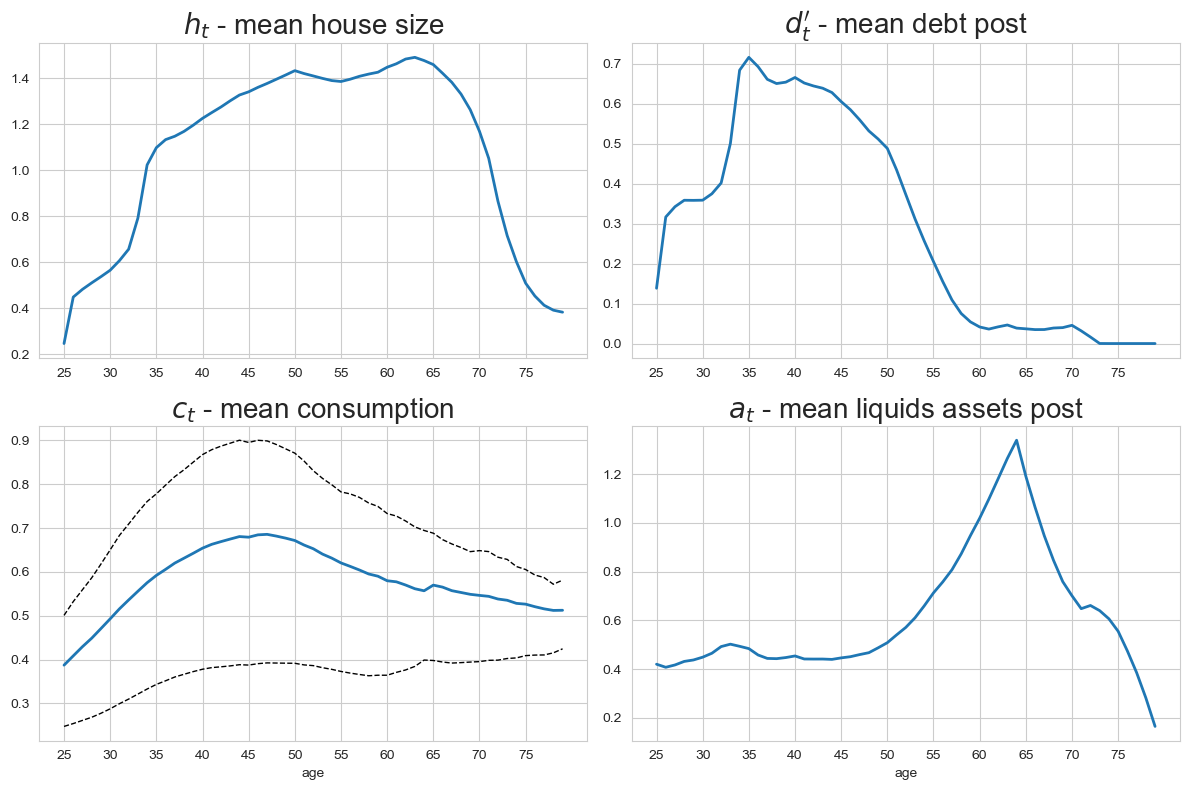

In [19]:
figs.lifecycle_full(model_nodeduct)

### 2.0 Aggregate moments in alternative model

In [20]:
names_targ_nd, moments_targ_nd = ana.model_moments_targ(model_nodeduct)
print('Targeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_targ_nd)):
    print(f'  {names_targ_nd[i]} = {moments_targ_nd[i]:.4f}')

Targeted moments from baseline model without interest rate deductibility:
  Aggregate net worth / (annual) labour income = 1.4041
  Annual fraction of houses sold = 0.0394
  Home ownership rate of <35 y.o. = 0.1922
  Mean NW at age 75 / mean NW at age 50 = 0.7329
  Share of households leaving no bequest = 0.4715
  Taxes to labour income = 0.3557


In [21]:
names_nd, moments_nd = ana.model_moments(model_nodeduct)
print('Untargeted moments from baseline model without interest rate deductibility:')
for i in range(len(names_nd)):
    print(f'  {names_nd[i]} = {moments_nd[i]:.4f}')

Untargeted moments from baseline model without interest rate deductibility:
  Homeowner share = 0.3596
  Mean house size = 3.0212
  Average housing expenditure = 0.0769
  Mean mortgage size = 1.8247
  Share of homeowners with mortgage = 0.4487
  DA mortgage share = 0.2455
  Average LTV ratio = 0.6440
  Average DTI ratio = 1.0845
  Gini wealth coefficient = 0.6863


### 2.1 Consumption equivalent variation between baseline and alternative

In [22]:
from simulate import calc_utility
from EconModel import jit

with jit(model_baseline) as model:
    calc_utility(model.sim,model.par)

assert len(np.unique(model_baseline.sim.utility)) == par.simN, 'utility is not unique'
assert np.sum(np.isinf(model_baseline.sim.utility)) == 0, 'there are individuals with negative infinite utility'

In [48]:
N = 10_000
cev_container = np.zeros(N)

for n in range(N):
    root = ana.find_cev_direct(model_baseline,model_nodeduct,n,do_print=False)
    cev_container[n] = (root-1)*100


array([ 1285.61,  -706.71, 10787.53, ..., 12483.67, -5137.46,   669.48])

mean ex ante CEV = 0.29 pct. (0.29 DKK)
median ex ante CEV = 0.06 pct.


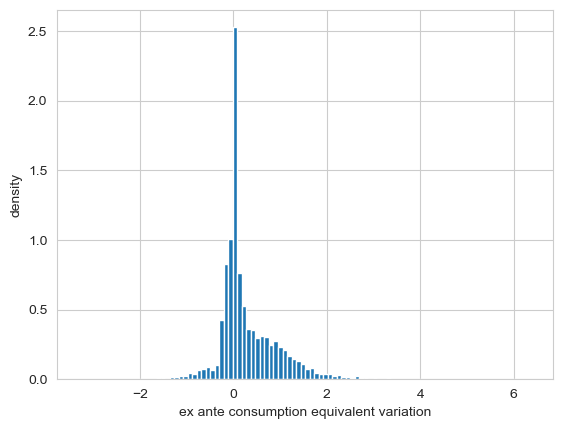

In [59]:
plt.hist(cev_container,bins=100,density=True,stacked=True)
plt.xlabel('ex ante consumption equivalent variation')
plt.ylabel('density');
print(f'mean ex ante CEV = {np.mean(cev_container):.2f} pct. ({np.mean(cev_container):.2f} DKK)')
print(f'median ex ante CEV = {np.median(cev_container):.2f} pct.')

## Debugging tools

### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [ ]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')
